In [0]:
!wget https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip
!python -m zipfile -e HE_Challenge_data.zip .

--2019-09-20 12:19:04--  https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip
Resolving he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)... 52.219.36.115
Connecting to he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)|52.219.36.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948965311 (905M) [application/zip]
Saving to: ‘HE_Challenge_data.zip’

HE_Challenge_data.z 100%[===================>] 905.00M  14.0MB/s    in 69s     

2019-09-20 12:20:19 (13.1 MB/s) - ‘HE_Challenge_data.zip’ saved [948965311/948965311]



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import torch
import fastai
from fastai import vision
from fastai import widgets as util

torch.manual_seed(999)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

fastai.core.defaults.device = torch.device(device)

if device == 'cuda':
    vision.torch.backends.cudnn.benchmark = True

device: cuda


In [0]:
path = vision.Path('data')
path

PosixPath('data')

In [0]:
path.ls()

[PosixPath('data/test'),
 PosixPath('data/test.csv'),
 PosixPath('data/train'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train.csv')]

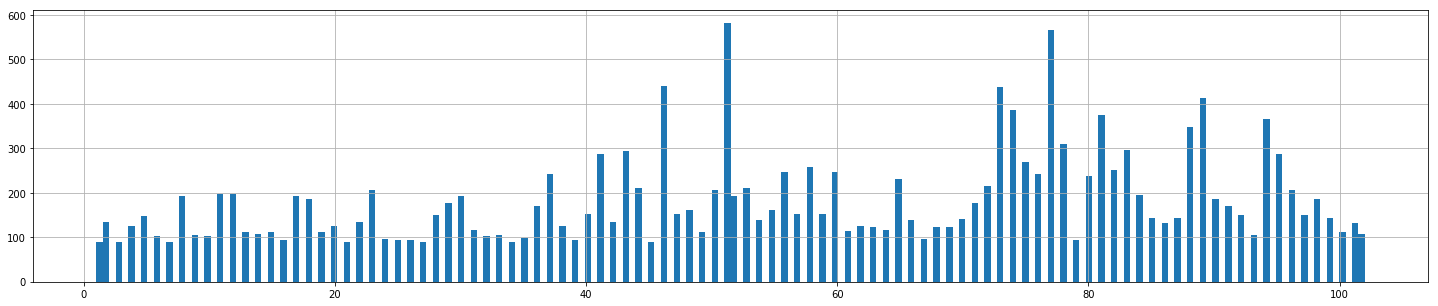

In [0]:
train_df = vision.pd.read_csv(path/'train.csv')
train_df['category'].hist(figsize = (20, 5), bins=200)

In [0]:
data = vision.ImageDataBunch.from_csv(path, folder='train', csv_labels='train.csv', 
                                      test = 'test', size=128,
                                      ds_tfms=vision.get_transforms(), bs=32,
                                      suffix='.jpg', seed=999).normalize(vision.imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
77,81,52,58,2
Path: data;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
5,60,44,60,93
Path: data;

Test: LabelList (2009 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data

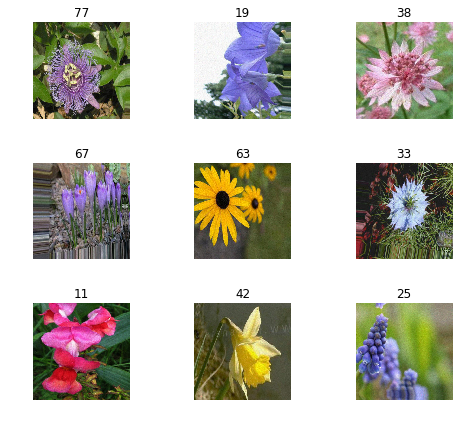

In [0]:
data.show_batch(3, figsize=(7, 6))

In [0]:
learner = vision.learner.cnn_learner(data, vision.models.resnet101, metrics=vision.accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 66255123.24it/s]


In [0]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 6.92E-03


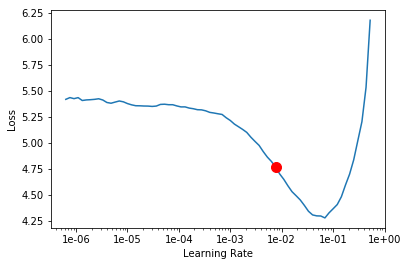

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [0]:
max_lr = 1e-2 / 2.
learner.fit_one_cycle(cyc_len=5, max_lr=max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.826987,0.745766,0.791262,04:13
1,0.659832,0.520766,0.857336,04:11
2,0.393484,0.186837,0.941208,04:10
3,0.169930,0.050846,0.985976,04:12
4,0.086836,0.033833,0.991640,04:27


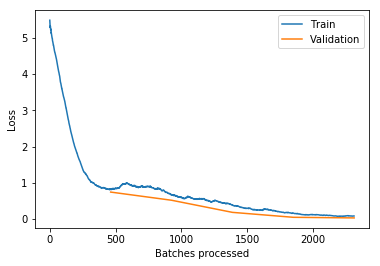

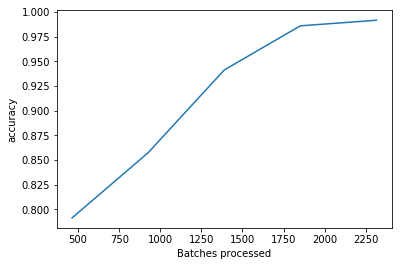

In [0]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [0]:
learner.save('inp_128_freeze_epoch_5')

In [134]:
pred, _ = learner.get_preds(ds_type = vision.DatasetType.Test)
y_pred = torch.argmax(pred, dim=1).numpy()

print(len(y_pred))

2009


In [135]:
y_pred = y_pred + 1
y_pred

array([32, 75, 46, 46, ..., 82, 60, 41, 76])

In [136]:
submit = pd.DataFrame()
submit['image_id'] = [f for f in os.listdir('data/test') if '.jpg' in f]
submit['image_id'] = submit['image_id'].apply(lambda x: x.split('.')[0])
submit['category'] = y_pred

submit.head()

,image_id,category
0,19400,32
1,19032,75
2,18772,46
3,18771,46
4,20424,77


In [137]:
submit.sort_values(by = ['image_id'], inplace=True)
submit.reset_index(inplace=True, drop=True)
submit.head()

,image_id,category
0,18540,9
1,18541,40
2,18542,96
3,18543,72
4,18544,51


In [0]:
submit.to_csv('submission.csv', index=False)